# Spatial dependency

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails):
    ratr = 6.25e14 * sensitivity_rf_contrails * ratio_erf_rf_contrails * efficacy_erf_contrails / time_horizon**0.843
    return ratr

time_horizon = 100
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

## Distance

In [3]:
file_path = 'seg_length_km_GAIA_2019.nc'
dsl = xr.open_dataset(file_path)
print(dsl)

# Somme sur toutes les latitudes et longitudes pour chaque variable souhaitée
sum_seg_length_km = dsl['seg_length_km'].sum(dim=['lat', 'lon']).item()
sum_seg_length_contrail_km = dsl['seg_length_contrail_km'].sum(dim=['lat', 'lon']).item()

print(f"Somme seg_length_km: {sum_seg_length_km}")
print(f"Somme seg_length_contrail_km: {sum_seg_length_contrail_km}")

<xarray.Dataset> Size: 1MB
Dimensions:                 (lat: 180, lon: 360)
Coordinates:
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                     (lon) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    seg_length_km           (lat, lon) float64 518kB ...
    seg_length_contrail_km  (lat, lon) float64 518kB ...
Somme seg_length_km: 60929593892.37307
Somme seg_length_contrail_km: 12505560816.768536


## RF and metrics

In [4]:
file_path = 'EF_and_RF_per_contrail_length_2019.nc'
file_path = 'output_mean.nc'

In [5]:
ds = xr.open_dataset(file_path)
print(ds)

rfd_mean = (ds['RF_net'] * ds['areacella']).sum(dim=['lat', 'lon']) / ds['areacella'].sum(dim=['lat', 'lon']) /sum_seg_length_km
print(rfd_mean)

atr_mean = ratr_contrails(time_horizon, rfd_mean, ratio_erf_rf_contrails, efficacy_erf_contrails)
print(atr_mean)

new_var_data = ds['RF_net'] / dsl['seg_length_km']
ds['RFD'] = new_var_data

print(ds['RFD'].where(np.isfinite(ds['RFD']), np.nan).mean().item())
print(ds['RF_lin'].where(np.isfinite(ds['RF_lin']), np.nan).mean().item())

rf_lin_cleaned = ds['RFD'].where(np.isfinite(ds['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon']) * dsl['seg_length_km'] / sum_seg_length_km

rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
mean_rf_transformed = rf_transformed.sum().item()
print(mean_rf_transformed)

<xarray.Dataset> Size: 3MB
Dimensions:       (lat: 180, lon: 360)
Coordinates:
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon           (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    RF_net        (lat, lon) float32 259kB ...
    areacella     (lat, lon) float64 518kB ...
    EF            (lat, lon) float64 518kB ...
    RF_lin_cotra  (lat, lon) float64 518kB ...
    RF_lin        (lat, lon) float64 518kB ...
    EF_lin_cotra  (lat, lon) float64 518kB ...
    EF_lin        (lat, lon) float64 518kB ...
<xarray.DataArray ()> Size: 8B
array(7.22283243e-13)
<xarray.DataArray ()> Size: 8B
array(3.90694095)
4.422215558020547e-07
4.422215564050804e-07
3.906683011094492


3.906683011094492


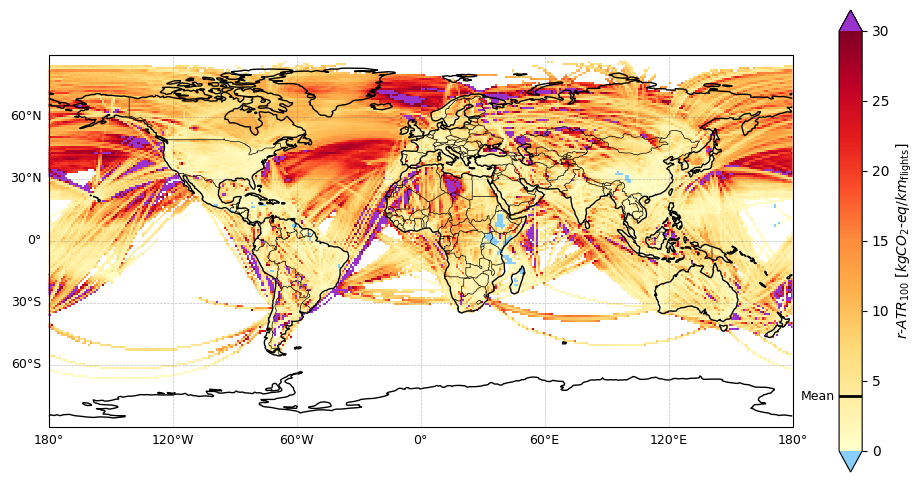

In [16]:
# rf_transformed est un xarray.DataArray
rf_lin_cleaned = ds['RFD'].where(np.isfinite(ds['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
data = rf_transformed

atr_i = rf_transformed * dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan) / sum_seg_length_km
mean_atr = atr_i.sum().item()
print(mean_atr)

Y = 1e4
data_masked = data.where(dsl['seg_length_km'] >= Y)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data_masked.values
# Choix des bornes sur les valeurs positives uniquement
vmin = 0
vmax = 30

# Copier les données pour modifier
plot_data = data_np.copy()

# Norme sym log avec prise en compte de la valeur spéciale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap avec NaN blanc et valeurs < vmin (négatifs) en noir
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))   # NaN en blanc
cmap.set_under('lightskyblue')       # valeurs sous vmin (négatifs) en bleu
cmap.set_over('darkorchid')

# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}


pcm = ax.pcolormesh(data['lon'], data['lat'], plot_data,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, extend='both')
cbar.ax.axhline(mean_atr, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_atr, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(r"$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km_{\text{flights}}$]", fontsize=10)

plt.savefig("map1.pdf")
plt.show()

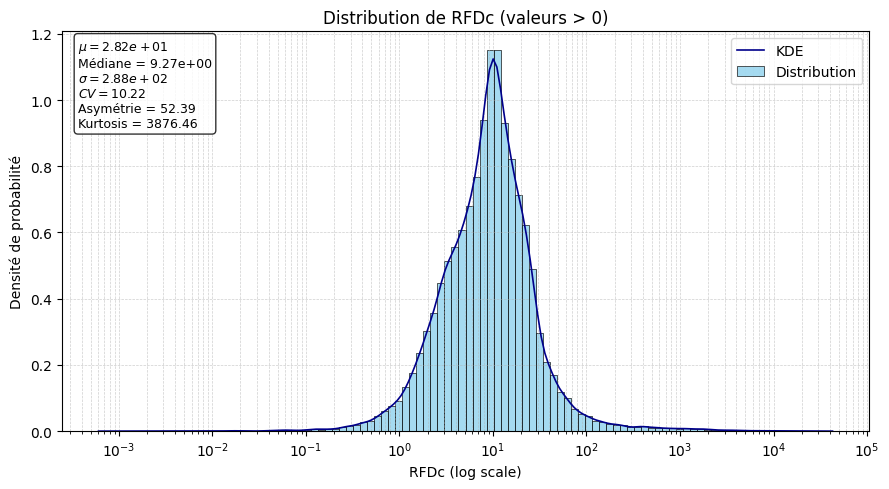

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Aplatir et filtrer les valeurs positives
rf_vals = rf_transformed.values.flatten()
rf_vals = rf_vals[np.isfinite(rf_vals) & (rf_vals > 0)]

# Calcul des indicateurs statistiques
mean = np.mean(rf_vals)
median = np.median(rf_vals)
std = np.std(rf_vals)
cv = std / mean  # Coefficient de variation
skw = skew(rf_vals)
krt = kurtosis(rf_vals)  # Fisher (k=0 for normal)

# Tracé
plt.figure(figsize=(9, 5))
sns.histplot(rf_vals, bins=100, stat="density", log_scale=(True, False), color='skyblue', label="Distribution")
sns.kdeplot(rf_vals, log_scale=True, color='darkblue', linewidth=1.2, label="KDE")

# Axe log en x
plt.xscale('log')
plt.xlabel("RFDc (log scale)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de RFDc (valeurs > 0)")

# Affichage des stats sur le graphique
textstr = '\n'.join((
    r'$\mu=%.2e$' % mean,
    r'Médiane = %.2e' % median,
    r'$\sigma=%.2e$' % std,
    r'$CV=%.2f$' % cv,
    r'Asymétrie = %.2f' % skw,
    r'Kurtosis = %.2f' % krt,
))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
new_var_data2 = ds['RF_net'] / dsl['seg_length_contrail_km']
ds['RFDc'] = new_var_data2

mean_rfdc = ds['RFDc'].where(np.isfinite(ds['RFDc']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon']) * dsl['seg_length_contrail_km'].where(np.isfinite(dsl['seg_length_contrail_km']), np.nan) / sum_seg_length_contrail_km

19.034141116889856


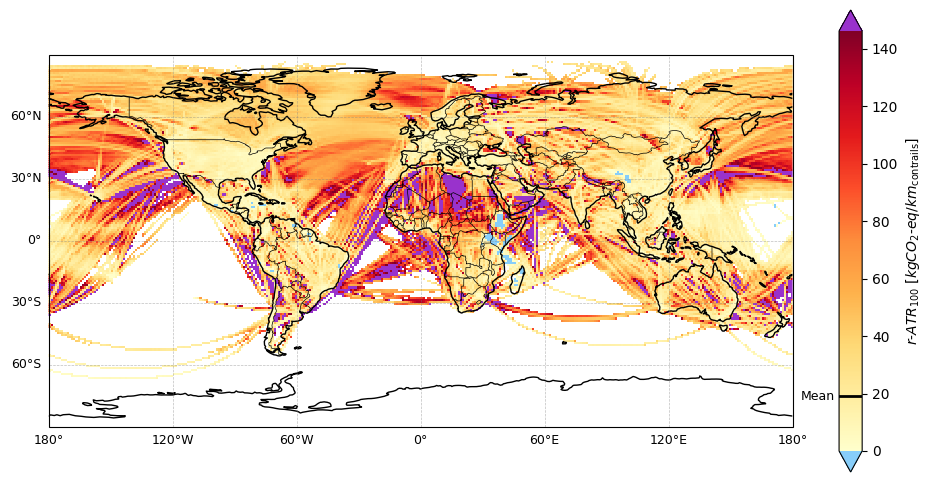

In [17]:
# rf_transformed est un xarray.DataArray
rf_lin_cleaned = ds['RFDc'].where(np.isfinite(ds['RFDc']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
data = rf_transformed

atr_c_i = rf_transformed * dsl['seg_length_contrail_km'].where(np.isfinite(dsl['seg_length_contrail_km']), np.nan) / sum_seg_length_contrail_km
mean_atr_c = atr_c_i.sum().item()
print(mean_atr_c)

# Convertir en numpy array (pour manipuler masques, valeurs)
Y = 1e4
data_masked = data.where(dsl['seg_length_km'] >= Y)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data_masked.values

# Choix des bornes sur les valeurs positives uniquement
vmin = 0
vmax = 30 * mean_atr_c/mean_atr

# Copier les données pour modifier
plot_data = data_np.copy()

# Norme sym log avec prise en compte de la valeur spéciale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap avec NaN blanc et valeurs < vmin (négatifs) en noir
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))   # NaN en blanc
cmap.set_under('lightskyblue')       # valeurs sous vmin (négatifs) en bleu
cmap.set_over('darkorchid')

# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

pcm = ax.pcolormesh(data['lon'], data['lat'], plot_data,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, extend='both')
cbar.ax.axhline(mean_atr_c, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_atr_c, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(r"$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km_{\text{contrails}}$]", fontsize=10)

plt.savefig("map2.pdf")
plt.show()

In [18]:
# Crée un masque booléen
mask = data_masked >= 30 * mean_atr_c/mean_atr

# Nombre de valeurs supérieures à vmin
count_sup = mask.sum().item()  # .item() pour obtenir un int

# Nombre total de valeurs non-NaN
total = data_masked.count().item()

# Fraction / pourcentage
fraction = count_sup / total
print(f"{count_sup}/{total} ({fraction:.2%})")

2129/37837 (5.63%)


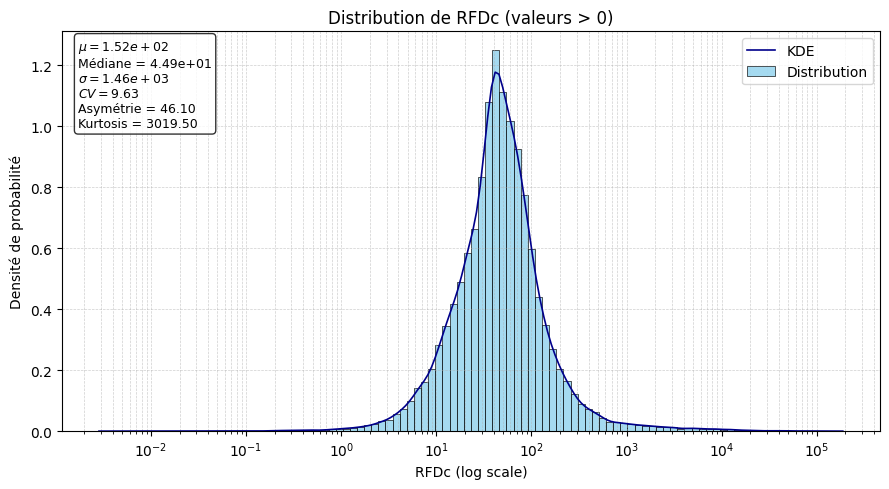

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Aplatir et filtrer les valeurs positives
rf_vals = rf_transformed.values.flatten()
rf_vals = rf_vals[np.isfinite(rf_vals) & (rf_vals > 0)]

# Calcul des indicateurs statistiques
mean = np.mean(rf_vals)
median = np.median(rf_vals)
std = np.std(rf_vals)
cv = std / mean  # Coefficient de variation
skw = skew(rf_vals)
krt = kurtosis(rf_vals)  # Fisher (k=0 for normal)

# Tracé
plt.figure(figsize=(9, 5))
sns.histplot(rf_vals, bins=100, stat="density", log_scale=(True, False), color='skyblue', label="Distribution")
sns.kdeplot(rf_vals, log_scale=True, color='darkblue', linewidth=1.2, label="KDE")

# Axe log en x
plt.xscale('log')
plt.xlabel("RFDc (log scale)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de RFDc (valeurs > 0)")

# Affichage des stats sur le graphique
textstr = '\n'.join((
    r'$\mu=%.2e$' % mean,
    r'Médiane = %.2e' % median,
    r'$\sigma=%.2e$' % std,
    r'$CV=%.2f$' % cv,
    r'Asymétrie = %.2f' % skw,
    r'Kurtosis = %.2f' % krt,
))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Other analyses

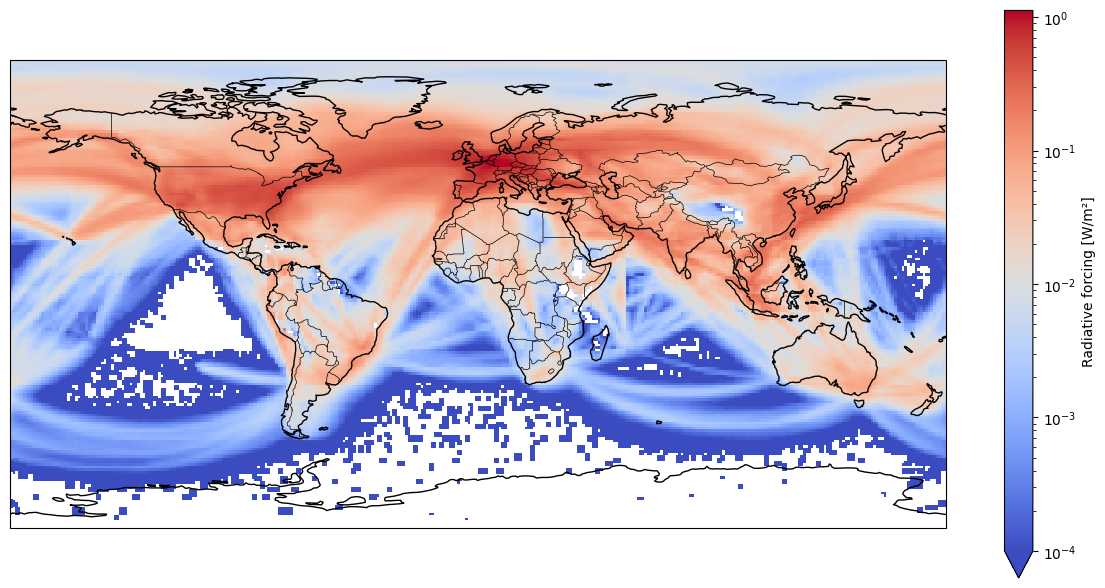

In [12]:
plt.figure(figsize=(12, 6))

# rf_transformed est un xarray.DataArray
rf_lin_cleaned = ds['RF_net'].where(np.isfinite(ds['RF_net']), np.nan)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data.values

# Définir les bornes log
vmin = 1e-4
vmax = np.nanmax(rf_lin_cleaned)

# Norme logarithmique
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))   # blanc transparent

# Projection de la carte
ax = plt.axes(projection=ccrs.PlateCarree())
rf_plot = plt.pcolormesh(ds['lon'], ds['lat'], rf_lin_cleaned,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

# Ajouter côtes et frontières
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

# Barre de couleur
cbar = plt.colorbar(rf_plot, ax=ax, extend='min')
cbar.set_label("Radiative forcing [W/m²]", fontsize=10)

plt.tight_layout()
plt.show()

0.2083650038227322


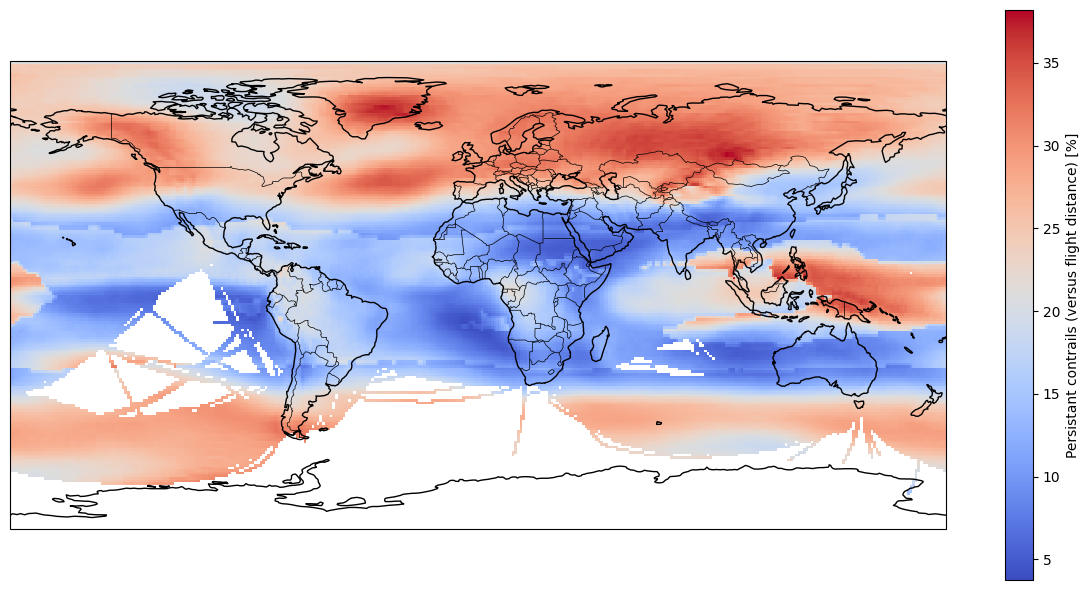

In [15]:
plt.figure(figsize=(12, 6))

# rf_transformed est un xarray.DataArray
rf_lin_cleaned = dsl['seg_length_contrail_km'].where(np.isfinite(dsl['seg_length_contrail_km']), np.nan)/dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan)
mean_contrails_share = rf_lin_cleaned.mean().item()
print(mean_contrails_share)
data = rf_lin_cleaned

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data.values

# Définir les bornes log
vmin = np.nanmin(100 * rf_lin_cleaned)
vmax = np.nanmax(100 * rf_lin_cleaned)

# Norme logarithmique
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))   # blanc transparent

# Projection de la carte
ax = plt.axes(projection=ccrs.PlateCarree())
rf_plot = plt.pcolormesh(ds['lon'], ds['lat'], 100 * rf_lin_cleaned,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

# Ajouter côtes et frontières
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

# Barre de couleur
cbar = plt.colorbar(rf_plot, ax=ax, extend=None)
cbar.set_label("Persistant contrails (versus flight distance) [%]", fontsize=10)

plt.tight_layout()
plt.show()

<xarray.DataArray 'seg_length_km' ()> Size: 8B
array(0.99941623)


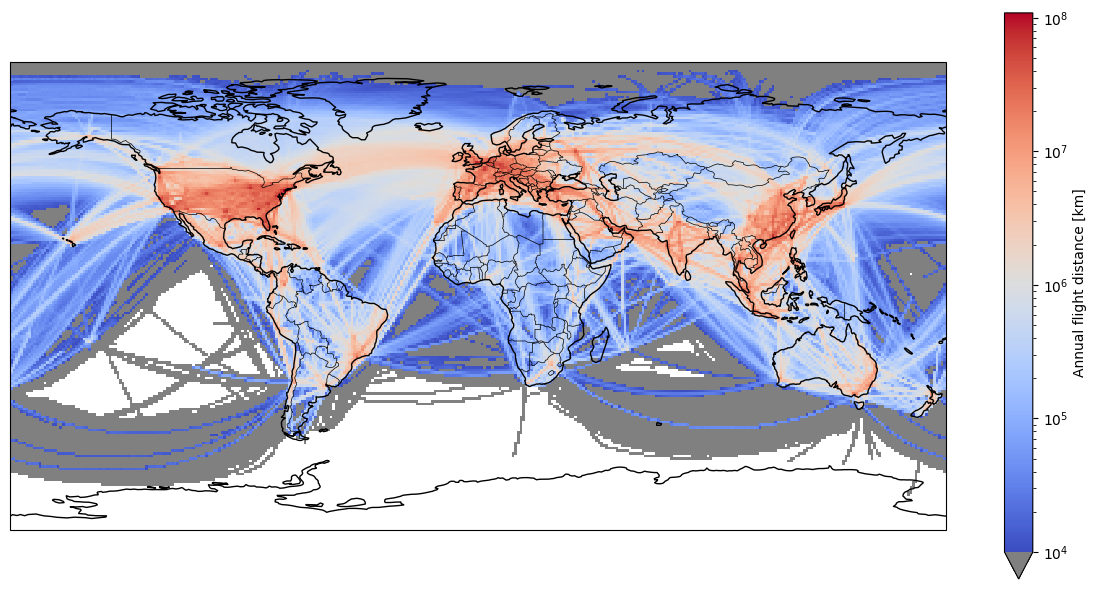

In [14]:
plt.figure(figsize=(12, 6))

rf_lin_cleaned = dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan)

# Définir les bornes log
vmin = 1e4   # seuil bas de la palette (gris en dessous)
vmax = np.nanmax(rf_lin_cleaned)

# Masquer les zéros → seront blancs (cmap.set_bad)
rf_masked = rf_lin_cleaned.where(rf_lin_cleaned > 0)

share = rf_lin_cleaned.where(rf_lin_cleaned > vmin).sum(dim=['lat', 'lon']) / rf_lin_cleaned.sum(dim=['lat', 'lon'])
print(share)

# Norme logarithmique
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))   # blanc transparent
cmap.set_under("grey")       # valeurs < vmin → gris

# Projection de la carte
ax = plt.axes(projection=ccrs.PlateCarree())
rf_plot = plt.pcolormesh(ds['lon'], ds['lat'], rf_masked,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

# Ajouter côtes et frontières
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

# Barre de couleur
cbar = plt.colorbar(rf_plot, ax=ax, extend="min")
cbar.set_label("Annual flight distance [km]", fontsize=10)

plt.tight_layout()
plt.show()